In [1]:
# import what we need
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt

from keras.layers.core import Dense, Activation
from keras.models import Sequential


from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

from mpl_toolkits.mplot3d import Axes3D

from scipy.cluster.hierarchy import dendrogram, linkage


Using TensorFlow backend.


In [3]:
# load original dataset
#from google.colab import files
#uploaded = files.upload()

dataset = pd.read_csv('diabetes.csv')
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


**Data Engineering - Data Cleaning**

In [4]:
# duplicate dataset for cleaning to remove rows with zero value in Glucose, BloodPressure, SkinThickness, Insulin, BMI
dataset_clean = dataset.copy(deep=True)
dataset_clean[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = dataset_clean[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
dataset_clean = dataset_clean.dropna()
dataset_clean

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
6,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
8,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
13,1,189.0,60.0,23.0,846.0,30.1,0.398,59,1
...,...,...,...,...,...,...,...,...,...
753,0,181.0,88.0,44.0,510.0,43.3,0.222,26,1
755,1,128.0,88.0,39.0,110.0,36.5,1.057,37,1
760,2,88.0,58.0,26.0,16.0,28.4,0.766,22,0
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0


**Feature Engineering**

Feature selection :


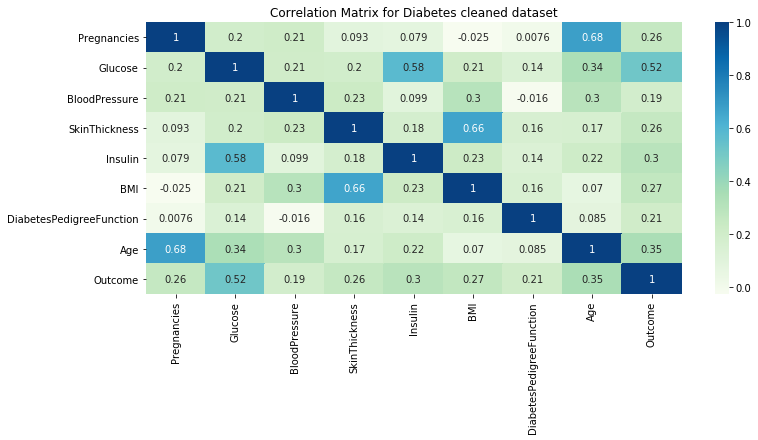

In [5]:
# correlation matrix

corr_mat = dataset_clean.corr()
plt.figure(figsize=(12,5))
sns.heatmap(data=corr_mat, annot=True, cmap='GnBu')
plt.title("Correlation Matrix for Diabetes cleaned dataset")
plt.show()

From the above correlation matrix, we can see that there are 2 pairs of features that has a **correlation value of above 0.6.** 

They are: 

1.   Pregancies and Age with a **correlation value of 0.68**
2.   BMI and SkinThickness with a **correlation value of 0.66**


From this, our group has decided to first **remove Pregnancies** as a feature, since it has a lower correlation value of 0.26 against outcome compared to age which has a correlation value of 0.35. 

We also decided to **remove SkinThickness** as a feature since it also has a slightly lower correlation value agains outcome compared to BMI. 

Moreover, Age and BMI are more generic features that are more applicable to most people, ie, not everyone might have been pregnant before and BMI is more easily measured compared to SkinThickness. 


PCA :

In [6]:
x = dataset_clean.iloc[:,:8].values
y = dataset_clean.iloc[:,8].values

x = StandardScaler().fit_transform(x)
pca = PCA(n_components=6)
pc = pca.fit_transform(x)
x

array([[-0.7174265 , -1.09104581, -0.37365481, ..., -0.710421  ,
        -1.03187632, -0.9682991 ],
       [-1.02921274,  0.46631407, -2.45696436, ...,  1.42673006,
         5.11511079,  0.2095853 ],
       [-0.09385402, -1.44794079, -1.65569146, ..., -0.29723846,
        -0.79712575, -0.47751393],
       ...,
       [-0.40564026, -1.12349081, -1.01467313, ..., -0.66767798,
         0.70411863, -0.87014206],
       [ 2.08864966, -0.70170584,  0.42761809, ..., -0.02653266,
        -1.0202837 ,  3.15429628],
       [ 0.52971846, -0.05280589,  0.10710893, ..., -0.9811268 ,
        -0.80582021, -0.0848858 ]])

In [7]:
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.31994031 0.19459756 0.14984544 0.11946188 0.09002175 0.05017765]
0.9240445949770016


**Unsupervised Technique - DBSCAN**

In [8]:
## DBSCAN
X = dataset_clean.iloc[:, [1,2,4,5,6,7]].values
Y = dataset_clean['Outcome'].values

Text(0, 0.5, 'k value')

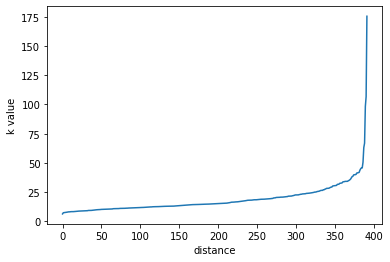

In [9]:
#The optimal value for epsilon will be found at the point of maximum curvature
neigh = NearestNeighbors(n_neighbors=3)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,2]
plt.plot(distances)

plt.xlabel('distance')
plt.ylabel('k value')


In [10]:
dbscan = DBSCAN(eps=35,min_samples = 5)
clusters = dbscan.fit_predict(X)

for i in np.unique(clusters):
    label = 'Outlier' if i == -1 else 'Cluster ' + str(i + 1)
    c = dataset_clean.iloc[clusters==i, 8]
    print(label + ': ', c.values, '\n')

Outlier:  [1 1 0 0 0 0 0 0 1 0 1 1 0 1 1 1 1] 

Cluster 1:  [0 1 1 1 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 0 0 0 0 0 1 0 0 1 0 1 0
 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 1 0 1 1 0 1 0 0 0 0
 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0
 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 1
 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0
 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0] 

Cluster 2:  [1 0 1 1 1 1 0 0 1] 



Text(0.5, 0, 'SkinThickness')

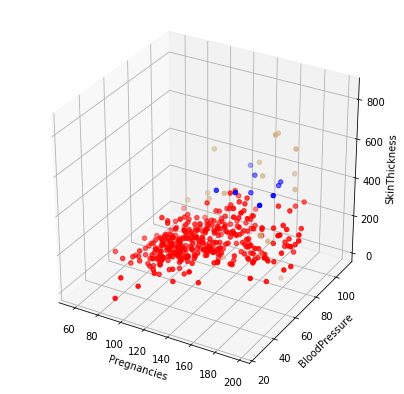

In [11]:
colors = [
    'red', 'blue', 'green', 'chocolate',
    'lightgreen', 'cornflowerblue',
    'violet', 'darkturquoise', 'lightskyblue',
    'magenta', 'yellowgreen', 'coral',
    'darkorange', 'mediumpurple',
    'olive', 'tan',
]

fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection='3d')

for i in np.unique(clusters):
    label = 'Outlier' if i == -1 else 'Cluster ' + str(i + 1)
    ax.scatter3D(X[clusters==i,0],
                 X[clusters==i,1],
                 X[clusters==i,2],
                 color=colors[i],
                 label=label)
    
ax.set_xlabel(dataset_clean.columns[0])
ax.set_ylabel(dataset_clean.columns[2])
ax.set_zlabel(dataset_clean.columns[3])

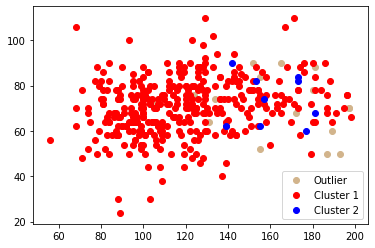

In [12]:
for i in np.unique(clusters):
    label = 'Outlier' if i == -1 else 'Cluster ' + str(i + 1)
    plt.scatter(X[clusters==i,0], 
                X[clusters==i,1],
                color=colors[i], label=label)

plt.legend()
plt.show()


**Unsupervised Technique - DBSCAN with PC** 

In [13]:
x = dataset_clean.iloc[:,:8].values
y = dataset_clean.iloc[:,8].values

x = StandardScaler().fit_transform(x)
pca = PCA(n_components=6)
pc = pca.fit_transform(x)

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())
x

[0.31994031 0.19459756 0.14984544 0.11946188 0.09002175 0.05017765]
0.9240445949770016


array([[-0.7174265 , -1.09104581, -0.37365481, ..., -0.710421  ,
        -1.03187632, -0.9682991 ],
       [-1.02921274,  0.46631407, -2.45696436, ...,  1.42673006,
         5.11511079,  0.2095853 ],
       [-0.09385402, -1.44794079, -1.65569146, ..., -0.29723846,
        -0.79712575, -0.47751393],
       ...,
       [-0.40564026, -1.12349081, -1.01467313, ..., -0.66767798,
         0.70411863, -0.87014206],
       [ 2.08864966, -0.70170584,  0.42761809, ..., -0.02653266,
        -1.0202837 ,  3.15429628],
       [ 0.52971846, -0.05280589,  0.10710893, ..., -0.9811268 ,
        -0.80582021, -0.0848858 ]])

Text(0, 0.5, 'k value')

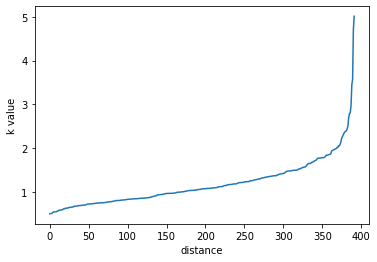

In [14]:
#PCA (The optimal value for epsilon will be found at the point of maximum curvature)
neigh = NearestNeighbors(n_neighbors=3)
nbrs = neigh.fit(pc)
distances, indices = nbrs.kneighbors(pc)

distances = np.sort(distances, axis=0)
distances = distances[:,2]
plt.plot(distances)

plt.xlabel('distance')
plt.ylabel('k value')


In [15]:
dbscan = DBSCAN(eps=1.2,min_samples = 4)
clusters = dbscan.fit_predict(pc)

for i in np.unique(clusters):
    label = 'Outlier' if i == -1 else 'Cluster ' + str(i + 1)
    c = dataset_clean.iloc[clusters==i, 8]
    print(label + ': ', c.values, '\n')

Outlier:  [1 1 1 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1
 1 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 1 1 1 1 1 0 0 1 0 0 0
 1 0 1 1 1 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 1 0 0 1 0 1 0
 1 0 1 0 1 1 0 1 1 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0] 

Cluster 1:  [0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 1
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 1 0 0 0] 

Cluster 2:  [1 0 0 0 1 0 0 0 0 1 1 0 1] 

Cluster 3:  [0 1 1 0 1] 

Cluster 4:  [1 1 1] 



Text(0.5, 0, 'Insulin')

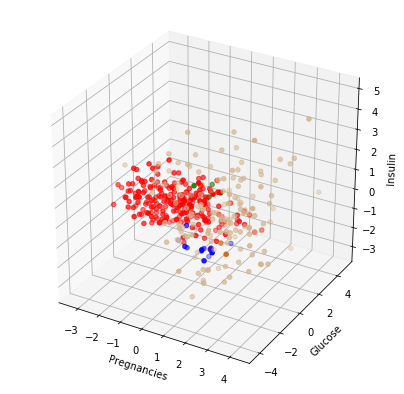

In [16]:
colors = [
    'red', 'blue', 'green', 'chocolate',
    'lightgreen', 'cornflowerblue',
    'violet', 'darkturquoise', 'lightskyblue',
    'magenta', 'yellowgreen', 'coral',
    'darkorange', 'mediumpurple',
    'olive', 'tan',
]

fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection='3d')

for i in np.unique(clusters):
    label = 'Outlier' if i == -1 else 'Cluster ' + str(i + 1)
    ax.scatter3D(pc[clusters==i,0],
                 pc[clusters==i,1],
                 pc[clusters==i,2],
                 color=colors[i],
                 label=label)
    

ax.set_xlabel(dataset_clean.columns[0])
ax.set_ylabel(dataset_clean.columns[1])
ax.set_zlabel(dataset_clean.columns[4])


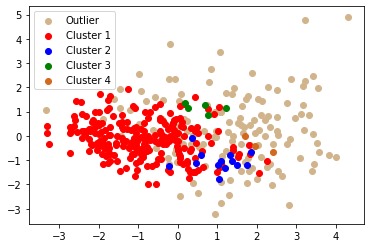

In [17]:
for i in np.unique(clusters):
    label = 'Outlier' if i == -1 else 'Cluster ' + str(i + 1)
    plt.scatter(pc[clusters==i,0], 
                pc[clusters==i,2],
                color=colors[i], label=label)

plt.legend()
plt.show()

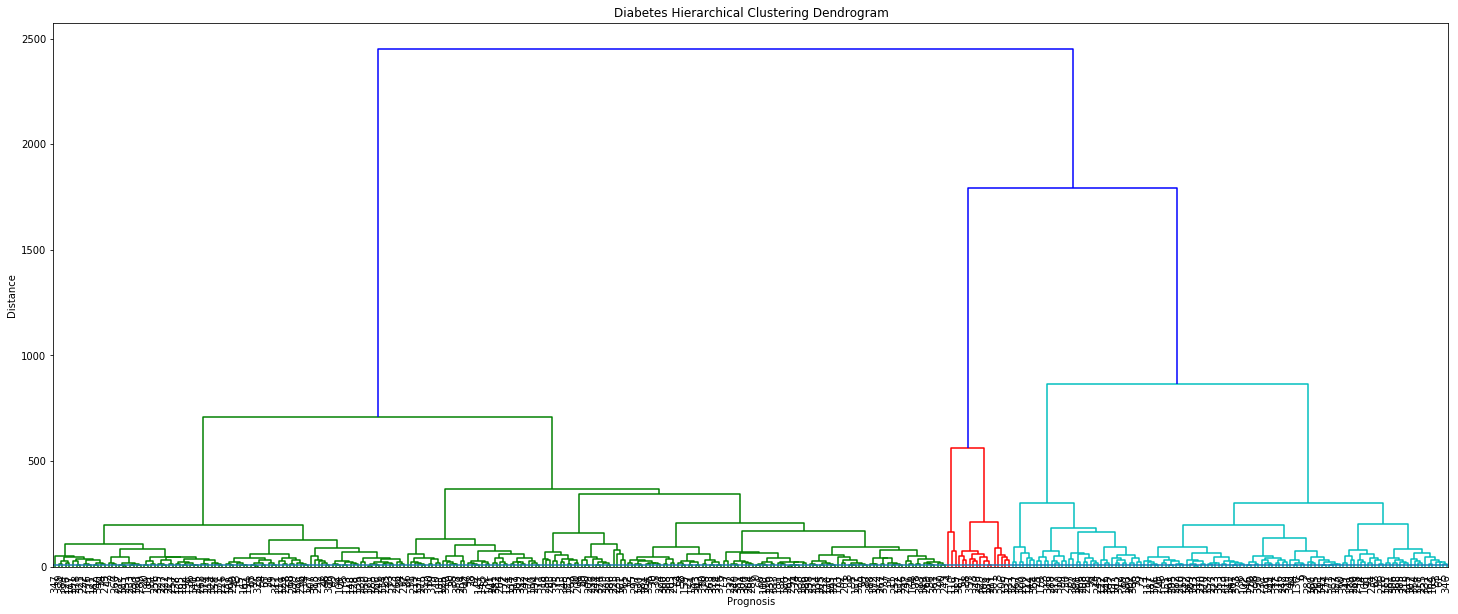

In [18]:
plt.figure(figsize=(25, 10))
plt.title('Diabetes Hierarchical Clustering Dendrogram')
plt.xlabel('Prognosis')
plt.ylabel('Distance')

dendrogram(
    linkage(X, 'ward'),
    leaf_font_size=10  
)

plt.axhline(y=10)
plt.show()

[1 0 1 0 0 0 0 1 1 0 1 1 1 1 0 1 0 0 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1
 1 0 1 1 0 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1 0
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 1 1 0 0 1 1 0
 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 0 0 0 1
 1 1 1 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 0 0 1 1 1 0
 1 1 0 0 1 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0 1
 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 1
 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 0 1 1 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0
 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1
 1 1 1 1 0 1 0 1 0 1 1 0 1 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0 1 0 1 0 1 0 0 0 0
 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1]


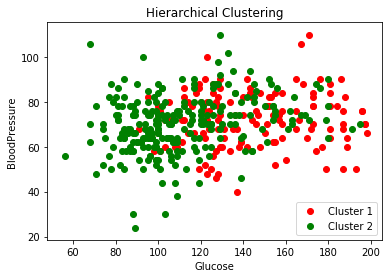

In [19]:
clustering = AgglomerativeClustering(linkage="ward", n_clusters=2)
clustering.fit(X)

print(clustering.labels_)

colors = 'rgbkcmy'

for i in np.unique(clustering.labels_):
    plt.scatter(X[clustering.labels_ == i, 0], X[clustering.labels_ == i, 1],
                color=colors[i], label='Cluster ' + str(i + 1))

plt.legend()

plt.title('Hierarchical Clustering')
plt.xlabel(dataset_clean.columns[1])
plt.ylabel(dataset_clean.columns[2])
plt.show()

Classification Technique - Hierarchical Clustering with PC


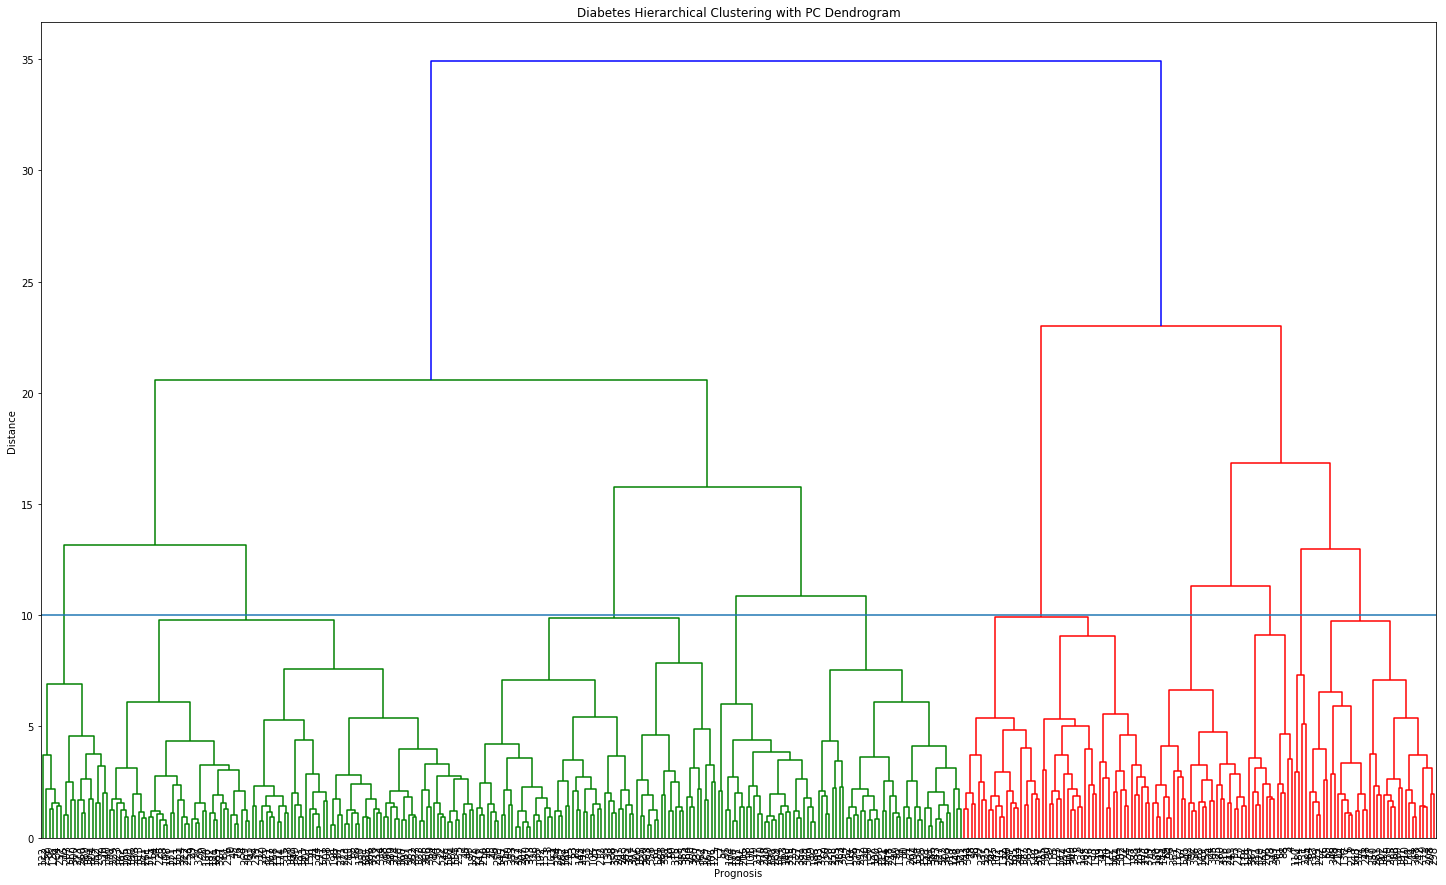

In [20]:
plt.figure(figsize=(25, 15))
plt.title('Diabetes Hierarchical Clustering with PC Dendrogram')
plt.xlabel('Prognosis')
plt.ylabel('Distance')

dendrogram(
    linkage(x, 'ward'),  
    leaf_font_size=10    
)

plt.axhline(y=10)
plt.show()

[1 0 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 1 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 0 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 0 0
 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 0 0 1 0 0 1 1 0 1 0 0 1 1 0 0 1 1 1 0 1 1 0
 1 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 0 1 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 1 1 0
 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 0 0 1 0 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 1 1 1 0 0 1 1 1
 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1
 1 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0
 1 1 1 1 1 1 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 0 1 0 1]


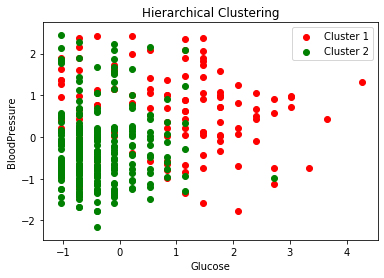

In [21]:
clustering = AgglomerativeClustering(linkage="ward", n_clusters=2)
clustering.fit(x)

print(clustering.labels_)

colors = 'rgbkcmy'

for i in np.unique(clustering.labels_):
    plt.scatter(x[clustering.labels_ == i, 0], x[clustering.labels_ == i, 1],
                color=colors[i], label='Cluster ' + str(i + 1))

plt.legend()

plt.title('Hierarchical Clustering')
plt.xlabel(dataset_clean.columns[1])
plt.ylabel(dataset_clean.columns[2])
plt.show()

**Unsupervised Technique - K-Means**

In [22]:
## K-Means

kmean = dataset_clean.iloc[:,:8].values
kmeans = KMeans(n_clusters = 2)
clusters = kmeans.fit_predict(kmean)
colors = 'cmy'

#print clusters outcomes
print('Cluster 1: ', dataset_clean.iloc[clusters==0, 8].values, '\n')
print('Cluster 2: ', dataset_clean.iloc[clusters==1, 8].values)

Cluster 1:  [0 1 1 1 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0
 1 1 0 1 1 1 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 1 1 0 0 1 1 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0
 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 1 0
 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 0 0
 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1
 0 0 0] 

Cluster 2:  [1 1 1 0 1 0 1 0 0 0 0 1 1 1 1 1 0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 0 1 1
 1 0 0 0 1 0 1 1 0 1 0 1 0 1 0 0 0 1 1]


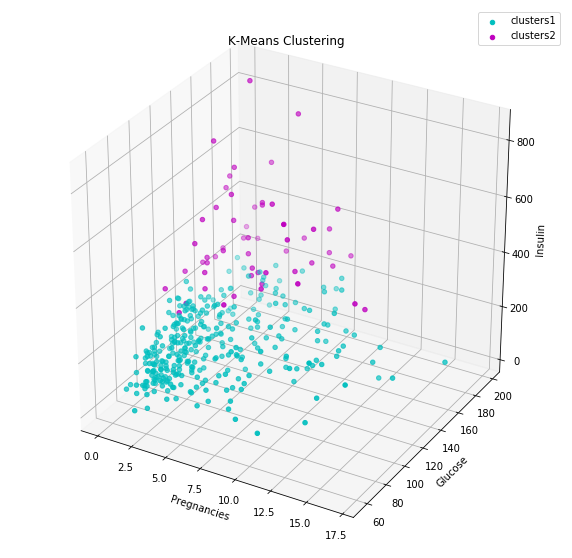

In [23]:
#print figure
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

for i in np.unique(clusters):
    ax.scatter3D(kmean[clusters==i,0],
                kmean[clusters==i,1],
                kmean[clusters==i,4],
                 color=colors[i], label='clusters' + str(i + 1))

ax.set_xlabel(dataset_clean.columns[0])
ax.set_ylabel(dataset_clean.columns[1])
ax.set_zlabel(dataset_clean.columns[4])

plt.legend()
plt.title('K-Means Clustering')
plt.show()

**KMeans with PC**

In [24]:
y = dataset_clean.iloc[:,8].values
x = StandardScaler().fit_transform(dataset_clean.iloc[:,:8])
pca = PCA(n_components=6)
pc = pca.fit_transform(x)
x

array([[-0.7174265 , -1.09104581, -0.37365481, ..., -0.710421  ,
        -1.03187632, -0.9682991 ],
       [-1.02921274,  0.46631407, -2.45696436, ...,  1.42673006,
         5.11511079,  0.2095853 ],
       [-0.09385402, -1.44794079, -1.65569146, ..., -0.29723846,
        -0.79712575, -0.47751393],
       ...,
       [-0.40564026, -1.12349081, -1.01467313, ..., -0.66767798,
         0.70411863, -0.87014206],
       [ 2.08864966, -0.70170584,  0.42761809, ..., -0.02653266,
        -1.0202837 ,  3.15429628],
       [ 0.52971846, -0.05280589,  0.10710893, ..., -0.9811268 ,
        -0.80582021, -0.0848858 ]])

In [25]:
kmeans_pc = KMeans(n_clusters = 2)
clusters_pc = kmeans_pc.fit_predict(x)
colors_2 = 'rgkcmy'

#print clusters outcomes
print('Cluster 1: ', dataset_clean.iloc[clusters_pc==0, 8].values, '\n')
print('Cluster 2: ', dataset_clean.iloc[clusters_pc==1, 8].values)

Cluster 1:  [0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0] 

Cluster 2:  [1 1 1 1 0 1 1 0 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 1 1 1 1
 0 1 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1
 1 0 1 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 1 1 1 1 0 0 1 0
 0 1 1 0 0 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 0 0 1 1
 1 0]


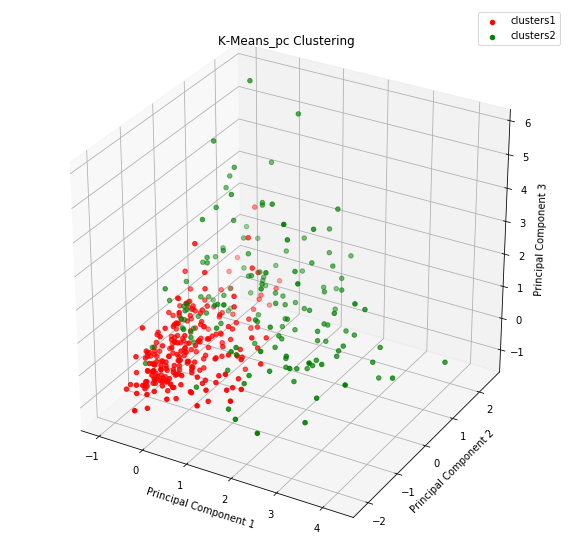

In [26]:
#print figure
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

for i in np.unique(clusters_pc):
    ax.scatter3D(x[clusters_pc==i,0],
                x[clusters_pc==i,1],
                x[clusters_pc==i,4],
                 color=colors_2[i], label='clusters' + str(i + 1))

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.legend()
plt.title('K-Means_pc Clustering')
plt.show()

**Classification Technique - Logistic Regression**

Visualization

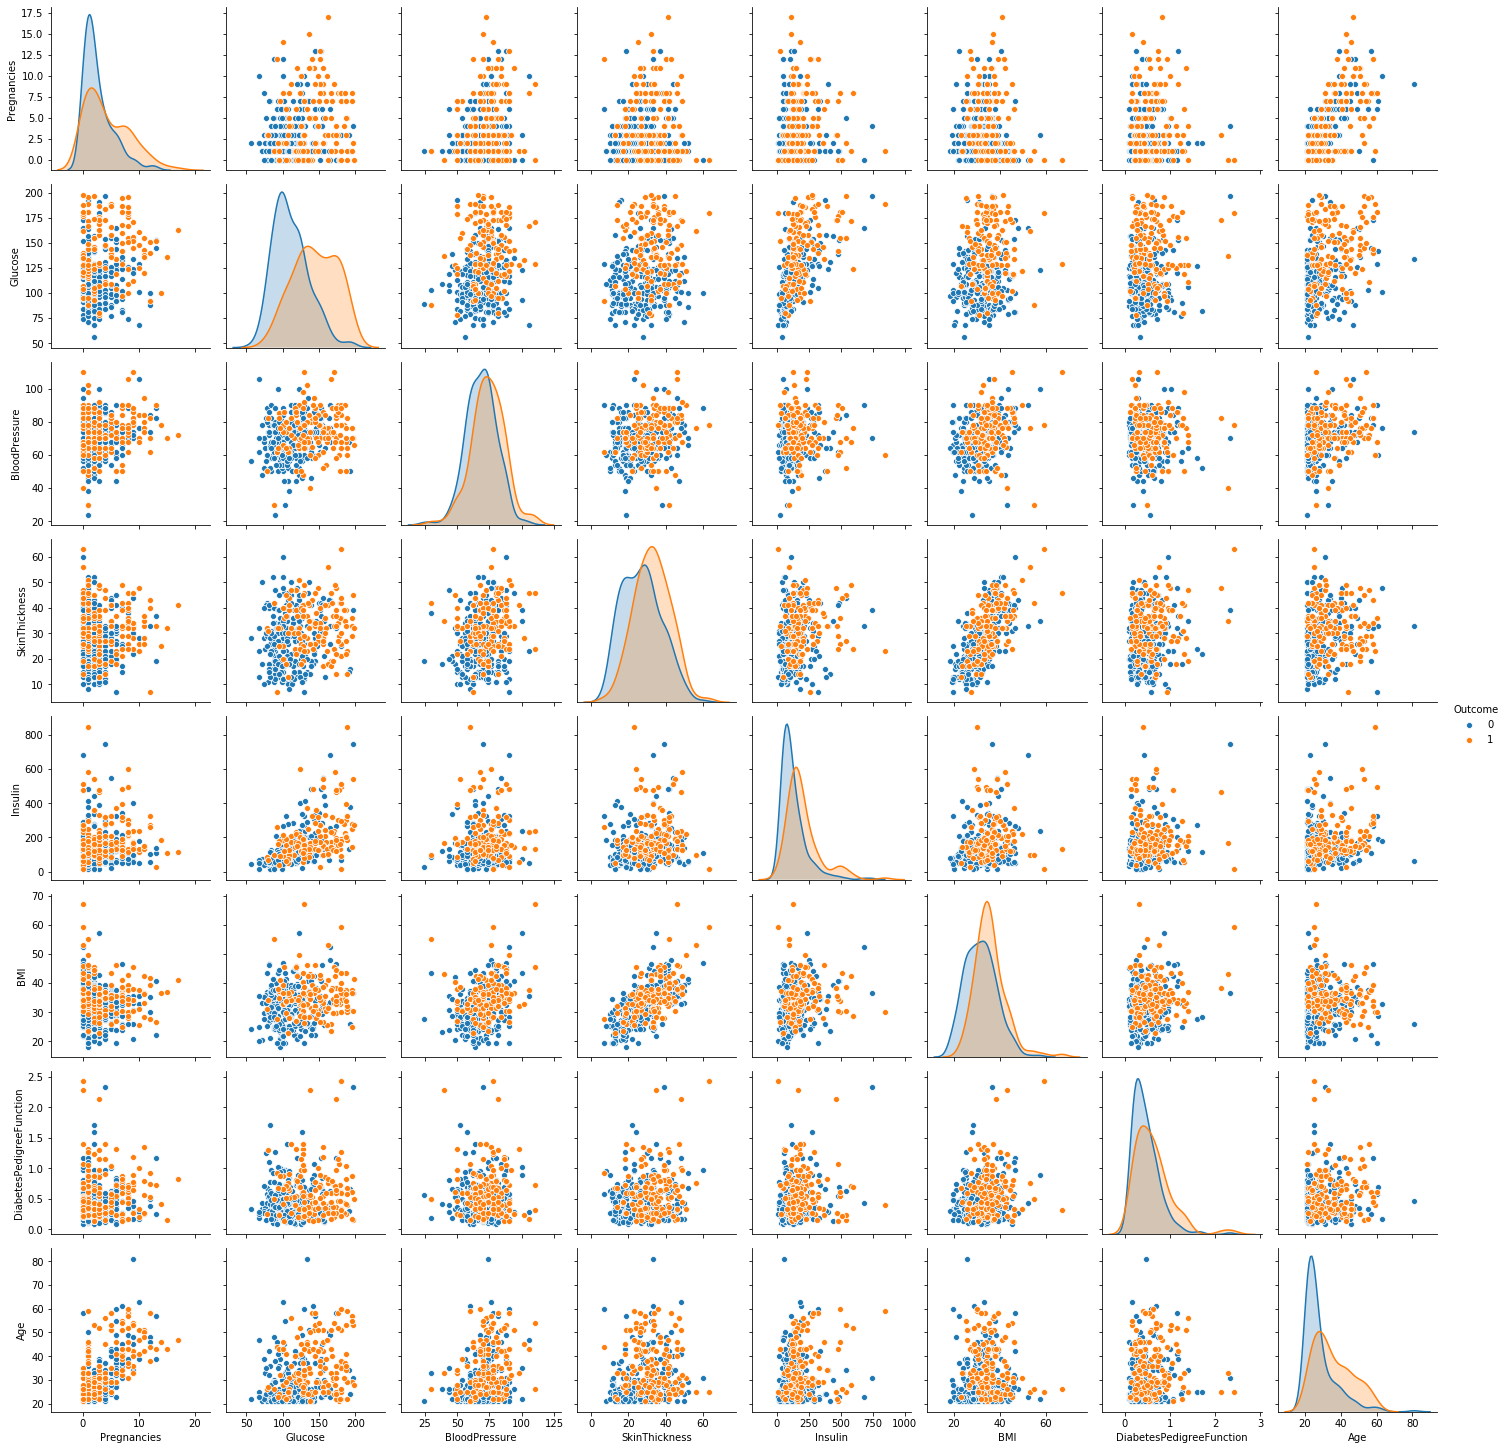

In [27]:
sns.pairplot (dataset_clean, hue='Outcome')  # Show different levels of a categorical variable by the color of plot elements
plt.show()

a. Model Training with all 8 features

In [28]:
X = dataset_clean.iloc[:, [0,1,2,3,4,5,6,7]]
Y = dataset_clean['Outcome']
from sklearn.linear_model import LogisticRegression

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 0)
logReg = LogisticRegression(solver = 'lbfgs')
start = time.time()
logReg.fit(x_train,y_train)
stop = time.time()
print(f"Training time: {stop - start}s")

Training time: 0.0359034538269043s


C:\apps\anaconda\envs\pythonEx\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
y_pred = logReg.predict(x_test)
print('Accuracy=',accuracy_score(y_test, y_pred))

Accuracy= 0.8061224489795918


In [0]:
confusion_matrix (y_test, y_pred, labels = [0,1])
logReg.predict([[8,100,66,30,200,33,0.3,25]]) 

In [0]:
#Probability
logReg.predict_proba(x_test)
logReg.predict_proba([[8,100,66,30,200,33,0.3,25]])

b. Model Training with 6 features

In [0]:
X = dataset_clean.iloc[:, [1,2,4,5,6,7]] # removed col 0 (pregnancies), 3 (skinthickness)
Y = dataset_clean['Outcome']
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 0)
logReg = LogisticRegression(solver = 'lbfgs')
start = time.time()
logReg.fit(x_train,y_train)
stop = time.time()
print(f"Training time: {stop - start}s")


In [0]:
y_pred = logReg.predict(x_test)
print('Accuracy=',accuracy_score(y_test, y_pred))


after remove the col 0 and 3, the accuracy is not changed.

In [0]:
confusion_matrix (y_test, y_pred, labels = [0,1])
logReg.predict([[100,66,200,33,0.3,25]]) 

In [0]:
#Probability
logReg.predict_proba(x_test)
logReg.predict_proba([[100,66,200,33,0.3,25]])

c. Modeling Training with Principal Components

In [0]:
x_train, x_test, y_train, y_test = train_test_split(pc, Y, random_state=0) 
logReg = LogisticRegression(solver = 'lbfgs')
start = time.time()
logReg.fit(x_train,y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
from sklearn.metrics import accuracy_score
y_pred = logReg.predict(x_test)
print('Accuracy=',accuracy_score(y_test, y_pred,))

**Classification Technique - K-NearestNeighbors**

a. Model Training with all 8 features

In [0]:
# set features and target
X = dataset_clean.iloc[:, [0,1,2,3,4,5,6,7]]
Y = dataset_clean['Outcome']
test_scores = []
train_scores = []

# split training and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)

for i in range(1,15,2):

    knn = KNeighborsClassifier(i)
    start=time.time()
    knn.fit(X_train,Y_train)
    stop=time.time()

    train_scores.append(knn.score(X_train,Y_train))
    test_scores.append(knn.score(X_test,Y_test))
  
max_train_score = max(train_scores)
train_scores_ind = [i for i, v in enumerate(train_scores) if v == max_train_score]
print('Max train score {} % and k = {}'.format(max_train_score*100,list(map(lambda x: x*2+1, train_scores_ind))))

## score that comes from testing on the datapoints that were split in the beginning to be used for testing solely
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100,list(map(lambda x: x*2+1, test_scores_ind))))

y_pred = knn.predict(X_test)
print(y_pred) 
print(Y_test)
print(f"Training time: {stop - start}s")

b. Model Training with 6 selected features

In [0]:
# set features and target
X = dataset_clean.iloc[:, [1,2,4,5,6,7]] # removed col 0 (pregnancies), 3 (skinthickness)
Y = dataset_clean['Outcome']
test_scores = []
train_scores = []


# split training and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0) 

for i in range(1,15,2):

    knn = KNeighborsClassifier(i)
    start=time.time()
    knn.fit(X_train,Y_train)
    stop=time.time()

    train_scores.append(knn.score(X_train,Y_train))
    test_scores.append(knn.score(X_test,Y_test))
  
max_train_score = max(train_scores)
train_scores_ind = [i for i, v in enumerate(train_scores) if v == max_train_score]
print('Max train score {} % and k = {}'.format(max_train_score*100,list(map(lambda x: x*2+1, train_scores_ind))))

## score that comes from testing on the datapoints that were split in the beginning to be used for testing solely
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100,list(map(lambda x: x*2+1, test_scores_ind))))

y_pred = knn.predict(X_test)
print(y_pred) 
print(Y_test) 
print(f"Training time: {stop - start}s")

c. Model Training with Principal Components

In [0]:
test_scores = []
train_scores = []

# use PC from feature engineering, split training and test data
X_train, X_test, Y_train, Y_test = train_test_split(pc, Y, random_state=0) 

for i in range(1,15,2):

    knn = KNeighborsClassifier(i)
    start=time.time()
    knn.fit(X_train,Y_train)
    stop=time.time()

    train_scores.append(knn.score(X_train,Y_train))
    test_scores.append(knn.score(X_test,Y_test))
  
max_train_score = max(train_scores)
train_scores_ind = [i for i, v in enumerate(train_scores) if v == max_train_score]
print('Max train score {} % and k = {}'.format(max_train_score*100,list(map(lambda x: x*2+1, train_scores_ind))))

## score that comes from testing on the datapoints that were split in the beginning to be used for testing solely
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100,list(map(lambda x: x*2+1, test_scores_ind))))

y_pred = knn.predict(X_test)
print(y_pred) 
print(Y_test) 
print(f"Training time: {stop - start}s")

**Classification Technique - Decision Trees**

a. Model Training with all 8 features

In [0]:
# set features and target
X = dataset_clean.iloc[:, [0,1,2,3,4,5,6,7]]
Y = dataset_clean['Outcome']
# split training and test data
X_train,x_test,Y_train,y_test=train_test_split(X,Y,random_state=0)
# Decision tree testing function
def decisiontreescore(crit='gini',maxdepth=None, minsampleleaf=1,minsamplesplit=2):
  dect=DecisionTreeClassifier(criterion=crit, max_depth=maxdepth, min_samples_leaf=minsampleleaf,min_samples_split=minsamplesplit,random_state=0)
  dect.fit(X_train,Y_train)
  accuracy=accuracy_score(y_test,dect.predict(x_test))
  print (accuracy)
  return accuracy

In [0]:
# Evaluating decision tree accuracy with different characteristics
# Current Decision Tree Score
decisiontreescore()
# change in criterion
decisiontreescore(crit='entropy')
# change in max_depth
for i in range(1,30,1):
  decisiontreescore(maxdepth=i)
# change in min_samples_leaf
for i in range(1,30,1):
  decisiontreescore(minsampleleaf=i)
# change in min_samples_split
for i in range(2,30,1):
  decisiontreescore(minsamplesplit=i)

In [0]:
# Decision Tree evaluation
dect2=DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=10,min_samples_split=4,random_state=0)
start = time.time()
dect2.fit(X_train,Y_train)
stop = time.time()
y_predict=dect2.predict(x_test)
print(f"Training time: {stop - start}s")
print("The accuracy_score is :",accuracy_score(y_test,y_predict))
print(confusion_matrix(y_test,y_predict,))

b. Model Training with 6 selected features

In [0]:
# set features and target
X = dataset_clean.iloc[:, [1,2,4,5,6,7]] # removed col 0 (pregnancies), 3 (skinthickness)
Y = dataset_clean['Outcome']
# split training and test data
X_train,x_test,Y_train,y_test=train_test_split(X,Y,random_state=0)

In [0]:
# Decision tree evaluation
dect2=DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=10,min_samples_split=4,random_state=0)
start = time.time()
dect2.fit(X_train,Y_train)
stop = time.time()
y_predict=dect2.predict(x_test)
print(f"Training time: {stop - start}s")
print("The accuracy_score is :",accuracy_score(y_test,y_predict))
print(confusion_matrix(y_test,y_predict))

c. Model Training with Principal Components

In [0]:
# split training and test data
X_train, x_test, Y_train, y_test = train_test_split(pc, Y, random_state=0) 

In [0]:
# Decision tree evaluation
dect2=DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=10,min_samples_split=4,random_state=0)
start = time.time()
dect2.fit(X_train,Y_train)
stop = time.time()
y_predict=dect2.predict(x_test)
print(f"Training time: {stop - start}s")
print("The accuracy_score is :",accuracy_score(y_test,y_predict))
print(confusion_matrix(y_test,y_predict))

**Classification Technique - Neural Network**

a. Model Training with all 8 features

In [0]:
# set features and target
X = dataset_clean.iloc[:, [0,1,2,3,4,5,6,7]]
Y = dataset_clean['Outcome']
Y = np.array(Y)

# split training and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0) # for OHE training
Y_train = np.reshape(Y_train, (294,1))
Y_test = np.reshape(Y_test, (98,1))

# One Hot Encoding
Y_train_ohe = np.array([[1,0] if a[0] == 1 else [0,1] for a in Y_train]) # positive outcome [1,0], negative [0,1]
Y_test_ohe = np.array([[1,0] if a[0] == 1 else [0,1] for a in Y_test])

model = Sequential()
model.add(Dense(360, input_shape=(8,), activation='sigmoid'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
start = time.time()
model.fit(X_train, Y_train_ohe, batch_size=64, epochs=200, verbose=1)
stop = time.time()
print(f"Training time: {stop - start}s")

In [0]:
# perform auto-evaluation
loss, accuracy = model.evaluate(X_test, Y_test_ohe, verbose=1)
print('Loss =', loss, ', Accuracy =', accuracy)

b. Model Training with 6 selected features

In [0]:
# set features and target
X = dataset_clean.iloc[:, [1,2,4,5,6,7]] # removed col 0 (pregnancies), 3 (skinthickness)
Y = dataset_clean['Outcome']
Y = np.array(Y)

# split training and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0) # for OHE training
Y_train = np.reshape(Y_train, (294,1))
Y_test = np.reshape(Y_test, (98,1))

# One Hot Encoding
Y_train_ohe = np.array([[1,0] if a[0] == 1 else [0,1] for a in Y_train]) # positive outcome [1,0], negative [0,1]
Y_test_ohe = np.array([[1,0] if a[0] == 1 else [0,1] for a in Y_test])

model = Sequential()
model.add(Dense(360, input_shape=(6,), activation='sigmoid'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
start = time.time()
model.fit(X_train, Y_train_ohe, batch_size=32, epochs=200, verbose=1)
stop = time.time()
print(f"Training time: {stop - start}s")

In [0]:
# perform auto-evaluation
loss, accuracy = model.evaluate(X_test, Y_test_ohe, verbose=1)
print('Loss =', loss, ', Accuracy =', accuracy)

c. Model Training with Principal Components

In [0]:
# use PC from feature engineering, split training and test data
X_train, X_test, Y_train, Y_test = train_test_split(pc, Y, random_state=0) 
Y_train = np.reshape(Y_train, (294,1))
Y_test = np.reshape(Y_test, (98,1))

# One Hot Encoding
Y_train_ohe = np.array([[1,0] if a[0] == 1 else [0,1] for a in Y_train]) # positive outcome [1,0], negative [0,1]
Y_test_ohe = np.array([[1,0] if a[0] == 1 else [0,1] for a in Y_test])

model = Sequential()
model.add(Dense(360, input_shape=(6,), activation='sigmoid'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
start = time.time()
model.fit(X_train, Y_train_ohe, batch_size=32, epochs=200, verbose=1)
stop = time.time()
print(f"Training time: {stop - start}s")

In [0]:
# perform auto-evaluation
loss, accuracy = model.evaluate(X_test, Y_test_ohe, verbose=1)
print('Loss =', loss, ', Accuracy =', accuracy)